In [5]:
import os
import pandas as pd
from datetime import datetime, timedelta
import csv
import matplotlib.pyplot as plt

## Compute Fidelity Data

In [6]:
def get_pickups_dropoffs(
        sf_rides_stats_path,
        start_date_str,
        start_time_str,
        end_date_str,
        end_time_str
    ):
    start_date = datetime.strptime(start_date_str, "%y%m%d").date()
    end_date = datetime.strptime(end_date_str, "%y%m%d").date()
    num_days = (end_date - start_date).days + 1

    # Parse start and end hours
    start_hour = int(datetime.strptime(start_time_str, "%H").hour)
    end_hour = int(datetime.strptime(end_time_str, "%H").hour)

    # Map dataset hours (3–26) to standard 0–23 format
    dataset_hour_map = {h: h % 24 for h in range(3, 27)}

    # Read the CSV file    
    all_rows = []
    with open(sf_rides_stats_path, mode='r') as file:
        reader = csv.DictReader(file, delimiter=',')
        for row in reader:
            row['taz'] = int(row['taz'])
            row['day_of_week'] = int(row['day_of_week'])
            row['hour'] = int(row['hour'])
            row['pickups'] = round(float(row['pickups']))
            row['dropoffs'] = round(float(row['dropoffs']))
            all_rows.append(row)

    # Index by (day_of_week, hour, taz)
    data_by_key = {}
    for row in all_rows:
        key = (row['day_of_week'], row['hour'], row['taz'])
        data_by_key[key] = {'pickups': row['pickups'], 'dropoffs': row['dropoffs']}

    zone_data = {}
    # For each simulation day, determine hours to include from that day
    for sim_day_index in range(num_days):
        sim_date = start_date + timedelta(days=sim_day_index)
        sim_day_of_week = sim_date.weekday()
        if num_days == 1:
            selected_std_hours = list(range(start_hour, end_hour))
        else:
            if sim_day_index == 0:
                selected_std_hours = list(range(start_hour, 24))
            elif sim_day_index == num_days - 1:
                selected_std_hours = list(range(0, end_hour))
            else:
                selected_std_hours = list(range(0, 24))
        selected_dataset_hours = {h: std for h, std in dataset_hour_map.items() if std in selected_std_hours}
        # Filter rows for this day and hour
        for row in all_rows:
            taz = row['taz']
            hour = row['hour']
            day = row['day_of_week']
            if day == sim_day_of_week and hour in selected_dataset_hours:
                std_hour = selected_dataset_hours[hour]
                if taz not in zone_data:
                    zone_data[taz] = {}
                zone_data[taz][std_hour] = {
                    'pickups': row['pickups'],
                    'dropoffs': row['dropoffs']
                }

    # Compute pickups and dropoffs across all zones and selected hours
    total_pickups = sum(hour_data['pickups'] for zone in zone_data.values() for hour_data in zone.values())
    total_dropoffs = sum(hour_data['dropoffs'] for zone in zone_data.values() for hour_data in zone.values())

    return total_pickups, total_dropoffs


def percent_error(true_val, estimated_val):
    return 100 * abs(true_val - estimated_val) / true_val if true_val != 0 else float('nan')

In [7]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
modes_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal')
traffic_dir = os.path.join(projectPath, 'data/sf_traffic/sfmta_dataset')
sfcta_dir = os.path.join(projectPath, 'data/ridehailing_stats')

records = []
# Traverse each mode (sumo, social_groups, multi_agent)
for mode in os.listdir(modes_dir):
    mode_path = os.path.join(modes_dir, mode)
    if not os.path.isdir(mode_path):
        continue
    # Traverse each folder inside the mode
    for date in os.listdir(mode_path):
        date_path = os.path.join(mode_path, date)
        if not os.path.isdir(date_path):
            continue
        summary_path = os.path.join(date_path, 'sf_final_metrics.csv')
        # Get real traffic and pickup/dropoff data
        traffic_file = [f for f in os.listdir(traffic_dir) if os.path.isfile(os.path.join(traffic_dir, f)) and date in f]
        print(traffic_file)
        try:
            traffic_df = pd.read_csv(os.path.join(traffic_dir, traffic_file[0]))
        except:
            continue
        traffic = (len(traffic_df)-1) if traffic_file else 0
        # Scale traffic: 36% of traffic is TNC
        traffic_scaled = int(traffic * 0.64)
        start_str, end_str = date.split('_')
        pickups, dropoffs = get_pickups_dropoffs(
            os.path.join(sfcta_dir, "trip_stats_taz.csv"),
            start_str[:6],
            start_str[6:],
            end_str[:6],
            end_str[6:]
        )
        if os.path.exists(summary_path):
            df = pd.read_csv(summary_path)
            if not df.empty:
                traffic_count = sum(df['traffic_departures'])
                pickup_count = sum(df['passengers_departures'])
                dropoff_count = sum(df['passengers_arrivals'])
                canceled_count = sum(df['passengers_cancel']) + sum(df['rides_not_served'])
                traffic_error = percent_error(traffic_scaled, traffic_count)
                pickup_error = percent_error(pickups, pickup_count)
                dropoff_error = percent_error(dropoffs, dropoff_count)
                pickup_scaled_error = percent_error(pickups, pickup_count + canceled_count)
                dropoff_scaled_error = percent_error(dropoffs, dropoff_count + canceled_count)
                records.append({
                    'mode': mode,
                    'date': date,
                    'traffic_input': traffic_scaled,
                    'pickup_input': pickups,
                    'dropoff_input': dropoffs,
                    'traffic_output': traffic_count,
                    'pickup_output': pickup_count,
                    'dropoff_output': dropoff_count,
                    'traffic_error': round(traffic_error, 2),
                    'pickup_error': round(pickup_error, 2),
                    'dropoff_error': round(dropoff_error, 2),
                    'canceled_rides': canceled_count,
                    'pickup_scaled_error': round(pickup_scaled_error, 2),
                    'dropoff_scaled_error': round(dropoff_scaled_error, 2)
                })

# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/fidelity_results_normal_1.csv')
summary_df = summary_df.sort_values(by=['mode', 'date'])
summary_df.to_csv(output_file, index=False)

print(f"Fidelity summary saved to: {output_file}")


[]
[]
[]
['sf_traffic_data_21062708_21062711.csv']
['sf_traffic_data_21100620_21100623.csv']
['sf_traffic_data_21062308_21062314.csv']
['sf_traffic_data_21111208_21111214.csv']
['sf_traffic_data_21111220_21111302.csv']
['sf_traffic_data_21062508_21062509.csv']
['sf_traffic_data_21111408_21111409.csv']
['sf_traffic_data_21111220_21111223.csv']
[]
['sf_traffic_data_21100608_21100614.csv']
['sf_traffic_data_21100620_21100702.csv']
['sf_traffic_data_21062720_21062721.csv']
['sf_traffic_data_21100808_21100811.csv']
[]
['sf_traffic_data_21100608_21100609.csv']
[]
[]
[]
['sf_traffic_data_21111420_21111502.csv']
[]
['sf_traffic_data_21101020_21101021.csv']
[]
['sf_traffic_data_21111408_21111414.csv']
['sf_traffic_data_21062508_21062514.csv']
[]
[]
['sf_traffic_data_21111208_21111209.csv']
['sf_traffic_data_21101008_21101011.csv']
['sf_traffic_data_21062308_21062309.csv']
[]
['sf_traffic_data_21111020_21111021.csv']
['sf_traffic_data_21100820_21100821.csv']
[]
['sf_traffic_data_21111208_2111121

## Plot Fidelity Data

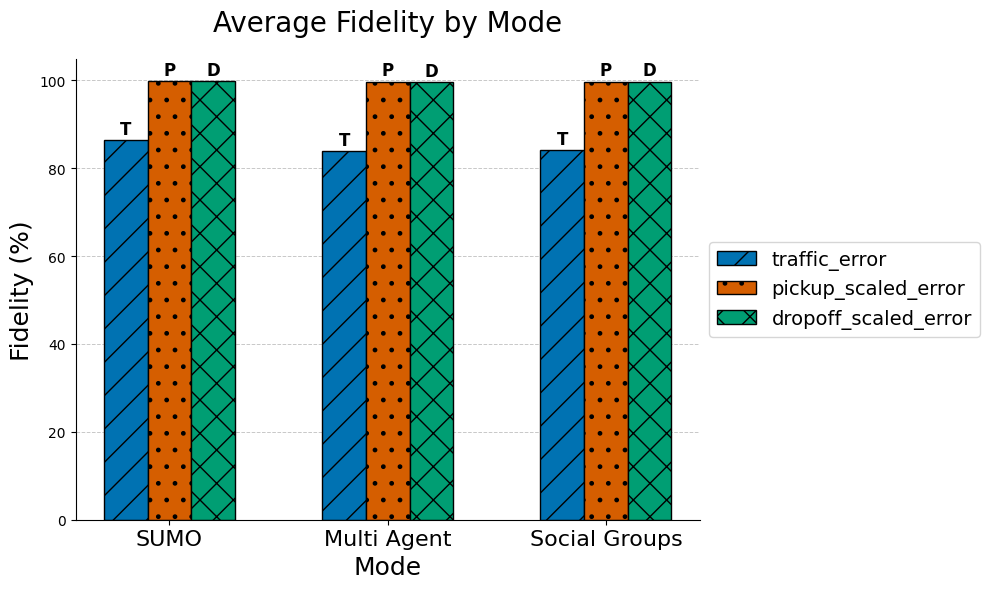

In [8]:
output_file = os.path.join(projectPath, 'experiments/fidelity_results_normal_1.csv')
df_fidelity = pd.read_csv(output_file)

# Adjust fidelity dataframe
df_fidelity_accuracy = 100 - df_fidelity.groupby('mode')[['traffic_error', 'pickup_scaled_error', 'dropoff_scaled_error']].mean()
df_fidelity_accuracy = df_fidelity_accuracy.reindex(['sumo', 'multi_agent', 'social_groups'])

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
x = range(len(df_fidelity_accuracy))

colors = ['#0072B2', '#D55E00', '#009E73']
hatches = ['/', '.', 'x']
labels = ['T', 'P', 'D']

for i, column in enumerate(df_fidelity_accuracy.columns):
    positions = [p + bar_width * i for p in x]
    bars = ax.bar(positions, df_fidelity_accuracy[column], width=bar_width,
                  label=column, color=colors[i], hatch=hatches[i], edgecolor='black')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height + 0.5, labels[i],
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Axis labels and ticks
ax.set_title('Average Fidelity by Mode', fontsize=20, pad=20)
ax.set_xlabel('Mode', fontsize=18)
ax.set_ylabel('Fidelity (%)', fontsize=18)
ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(['SUMO', 'Multi Agent', 'Social Groups'], fontsize=16)

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add horizontal grid and legend
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.tight_layout()
plt.savefig("fidelity.png", dpi=300, bbox_inches='tight')
plt.show()